In [1]:
import numpy as np
np.set_printoptions(precision=6,suppress=True)
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.gf import BlockGf

from triqs_dft_tools.converters.vasp import VaspConverter 
import triqs_dft_tools.converters.plovasp.converter as plo_converter

import pymatgen.io.vasp.outputs as vio
from pymatgen.electronic_structure.dos import CompleteDos
from pymatgen.electronic_structure.core import Spin, Orbital, OrbitalType

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

Starting serial run at: 2022-03-08 18:08:41.300264


# AFM state of NdNiO2 with one-shot DMFT from Vasp

In this tutorial we will take a look at a magnetic DMFT calculation for NdNiO2 in the antiferromagnetic phase. NdNiO2 shows a clear AFM phase at lower temperatures in DFT+DMFT calculation. The calculations will be performed for a large energy window with all Ni-$d$ orbitals treated as interacting with a density-density type interaction. 

Disclaimer: the interaction values, results etc. might not be 100% physical and are only for demonstrative purposes!

This tutorial will guide you through the following steps: 

* run a non-magnetic Vasp calculation for NdNiO2 with a two atom supercell allowing magnetic order
* create projectors in a large energy window for all Ni-$d$ orbitals and all O-$p$ orbitals
* create the hdf5 input via the Vasp converter for solid_dmft
* run a AFM DMFT one-shot calculation
* take a look at the output and analyse the multiplets of the Ni-d states

Warning: the DMFT calculations here are very heavy requiring ~2500 core hours for the DMFT job.


## 1. Run DFT 

We start by running Vasp to create the raw projectors. The [INCAR](INCAR), [POSCAR](POSCAR), and [KPOINTS](KPOINTS) file are kept relatively simple. For the POTCAR the `PBE Nd_3`, `PBE Ni_pv` and `PBE O` pseudo potentials are used. Here we make sure that the Kohn-Sham eigenstates are converged well (rms), meaning performing quite a few extra SCF steps here by setting `NELMIN=30`. We tell Vasp to create projectors for the Ni-$d$ shell by setting the INCAR flag `LOCPROJ = LOCPROJ = 3 4 : d : Pr`. More information can be found on the [DFTTools webpage of the Vasp converter](https://triqs.github.io/dft_tools/unstable/guide/conv_vasp.html).

Let's run Vasp with 
```
mpirun vasp_std 1>out.vasp 2>err.vasp &
```
and monitor the output. After Vasp is finished the result should look like this: 

In [2]:
!tail -n 10 out.vasp

DAV:  25    -0.569483098581E+02   -0.31832E-09    0.42131E-12 29952   0.148E-06    0.488E-07
DAV:  26    -0.569483098574E+02    0.75124E-09    0.25243E-12 30528   0.511E-07    0.226E-07
DAV:  27    -0.569483098574E+02   -0.12733E-10    0.17328E-12 28448   0.285E-07    0.826E-08
DAV:  28    -0.569483098578E+02   -0.41837E-09    0.17366E-12 29536   0.151E-07    0.370E-08
DAV:  29    -0.569483098576E+02    0.22192E-09    0.19300E-12 29280   0.689E-08    0.124E-08
DAV:  30    -0.569483098572E+02    0.38563E-09    0.27026E-12 28576   0.388E-08    0.598E-09
DAV:  31    -0.569483098573E+02   -0.92768E-10    0.34212E-12 29024   0.218E-08
 LOCPROJ mode
 Computing AMN (projections onto localized orbitals)
   1 F= -.56948310E+02 E0= -.56941742E+02  d E =-.131358E-01


let us take a look at the density of states from Vasp:

In [3]:
vasprun = vio.Vasprun('vasprun.xml')
dos = vasprun.complete_dos
Ni_spd_dos = dos.get_element_spd_dos("Ni")
O_spd_dos = dos.get_element_spd_dos("O")
Nd_spd_dos = dos.get_element_spd_dos("Nd")

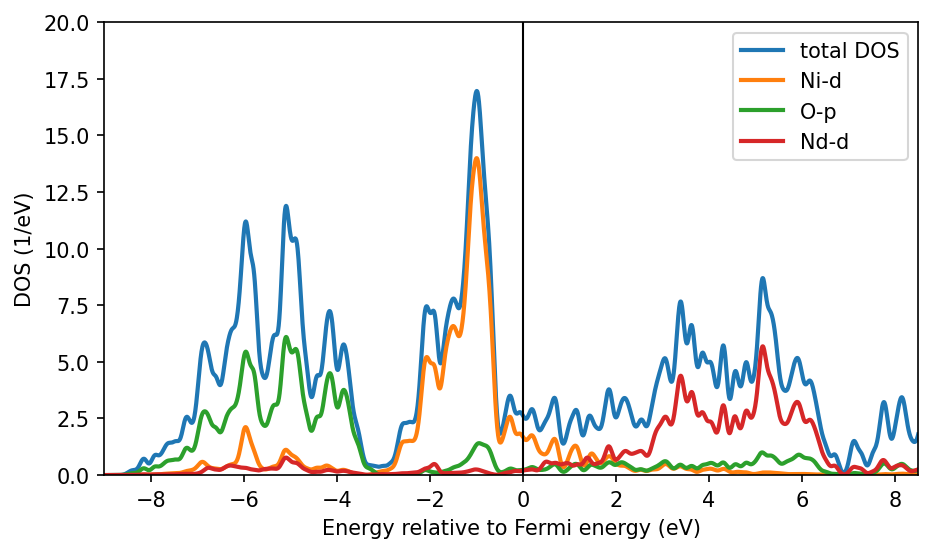

In [4]:
fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))

ax.plot(vasprun.tdos.energies - vasprun.efermi , vasprun.tdos.densities[Spin.up], label=r'total DOS', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , Ni_spd_dos[OrbitalType.d].densities[Spin.up], label=r'Ni-d', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , O_spd_dos[OrbitalType.p].densities[Spin.up], label=r'O-p', lw = 2)
ax.plot(vasprun.tdos.energies - vasprun.efermi , Nd_spd_dos[OrbitalType.d].densities[Spin.up], label=r'Nd-d', lw = 2)

ax.axvline(0, c='k', lw=1)
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
ax.set_xlim(-9,8.5)
ax.set_ylim(0,20)
ax.legend()
plt.show()

We see that the Ni-$d$ states are entangled / hybridizing with O-$p$ states and Nd-$d$ states in the energy range between -9 and 9 eV. Hence, we orthonormalize our projectors considering all states in this energy window to create well localized real-space states. These projectors will be indeed quite similar to the internal DFT+$U$ projectors used in VASP due to the large energy window. 

## 2. Creating the hdf5 archive / DMFT input

Next we run the [Vasp converter](https://triqs.github.io/dft_tools/unstable/guide/conv_vasp.html) to create an input h5 archive for solid_dmft. The [plo.cfg](plo.cfg) looks like this: 

In [5]:
!cat plo.cfg

[General]
BASENAME = nno

[Group 1]
SHELLS = 1
NORMALIZE = True
NORMION = False
EWINDOW = -10 10

[Shell 1]
LSHELL = 2
IONS = 3 4
TRANSFORM = 0.0  0.0  0.0  0.0  1.0
            0.0  1.0  0.0  0.0  0.0
            0.0  0.0  1.0  0.0  0.0
            0.0  0.0  0.0  1.0  0.0
            1.0  0.0  0.0  0.0  0.0


we create $d$ like projectors within a large energy window from -10 to 10 eV for very localized states for both Ni sites. Important: the sites are markes as non equivalent, so that we can later have different spin orientations on them. The flag `TRANSFORM` swaps the $d_{xy}$ and $d_{x^2 - y^2}$ orbitals, since the orientation in the unit cell of the oxygen bonds is rotated by 45 degreee. Vasp always performs projections in a global cartesian coordinate frame, so one has to rotate the orbitals manually with the octahedra orientation. 

Let's run the converter:

In [6]:
# Generate and store PLOs
plo_converter.generate_and_output_as_text('plo.cfg', vasp_dir='./')

# run the archive creat routine
conv = VaspConverter('nno')
conv.convert_dft_input()

Read parameters:
0  ->  {'label': 'dxy', 'isite': 3, 'l': 2, 'm': 0}
1  ->  {'label': 'dyz', 'isite': 3, 'l': 2, 'm': 1}
2  ->  {'label': 'dz2', 'isite': 3, 'l': 2, 'm': 2}
3  ->  {'label': 'dxz', 'isite': 3, 'l': 2, 'm': 3}
4  ->  {'label': 'dx2-y2', 'isite': 3, 'l': 2, 'm': 4}
5  ->  {'label': 'dxy', 'isite': 4, 'l': 2, 'm': 0}
6  ->  {'label': 'dyz', 'isite': 4, 'l': 2, 'm': 1}
7  ->  {'label': 'dz2', 'isite': 4, 'l': 2, 'm': 2}
8  ->  {'label': 'dxz', 'isite': 4, 'l': 2, 'm': 3}
9  ->  {'label': 'dx2-y2', 'isite': 4, 'l': 2, 'm': 4}
  Found POSCAR, title line: NdNiO2 SC
  Total number of ions: 8
  Number of types: 3
  Number of ions for each type: [2, 2, 4]

    Total number of k-points: 405
  No tetrahedron data found in IBZKPT. Skipping...
eigvals from LOCPROJ

  Unorthonormalized density matrices and overlaps:
  Spin: 1
  Site: 3
  Density matrix                                                  Overlap
   1.1544881   0.0000000  -0.0000000   0.0000000  -0.0000000       0.9626619 

We can here cross check the quality of our projectors by making sure that there are not imaginary elements in both the local Hamiltonian and the density matrix. Furthermore, we see that the occupation of the Ni-$d$ shell is roughly 8.5 electrons which is a bit different from the nominal charge of $d^9$ for the system due to the large hybridization with the other states. For mor physical insights into the systems and a discussion on the appropriate choice of projectors see this research article [PRB 103 195101 2021](https://doi.org/10.1103/PhysRevB.103.195101)

## 3. Running the AFM calculation

now we run the calculation at around 290 K, which should be below the ordering temperature of NdNiO2 in DMFT. The config file [config.ini](config.ini) for solid_dmft looks like this: 

    [general]
    seedname = nno
    jobname = NNO_lowT

    block_threshold = 0.001

    solver_type = cthyb
    n_iw = 8001
    n_tau = 40001

    prec_mu = 0.001

    h_int_type = density_density
    U = 8.0
    J = 1.0

    beta = 40

    magnetic = True
    magmom = -0.001, 0.001
    afm_order = True

    n_iter_dmft = 12

    g0_mix = 0.9

    dc_type = 0
    dc = True
    dc_dmft = False

    [solver]
    length_cycle = 150
    n_warmup_cycles = 10000
    n_cycles_tot = 2e+8
    imag_threshold = 1e-5

    perform_tail_fit = True
    fit_max_moment = 6
    fit_min_w = 8
    fit_max_w = 14
    measure_density_matrix = True

Let's go through some special options we set in the config file: 

* we changed `n_iw=8001` because the large energy window of the calculation requires more Matsubara frequencies
* `h_int_type` is set to `density_density` to reduce complexity of the problem
* `beta=40` here we set the temperature to ~290K
* `magnetic=True` lift spin degeneracy
* `magmom` here we specify the magnetic order. Here, we say that both Ni sites have the same spin, which should average to 0 at this high temperature. The magnetic moment is specified in units of the DC potential. Hence, small values should be chosen. 
* `afm_order=True` tells solid_dmft to not solve impurities with the same `magmom` but rather copy the self-energy and if necessary flip the spin accordingly
* `length_cycle=150` is the length between two Green's function measurements in cthyb. This number has to be choosen carefully to give an autocorrelation time <1
*  `perform_tail_fit=True` : here we use tail fitting to get good high frequency self-energy behavior
* `measure_density_matrix = True ` measures the impurity many-body density matrix in the Fock basis for a multiplet analysis

By setting the flag magmom to a small value with a flipped sign on both sites we tell solid_dmft that both sites are related by flipping the down and up channel. Now we run solid_dmft simply by executing `mpirun solid_dmft config.ini`. 

Caution: this is a very heavy job, which should be submitted on a cluster. 

In the beginning of the calculation we find the following lines:

    AFM calculation selected, mapping self energies as follows:
    imp  [copy sigma, source imp, switch up/down]
    ---------------------------------------------
    0: [False, 0, False]
    1: [True, 0, True]

this tells us that solid_dmft detected correctly how we want to orientate the spin moments. This also reflects itself during the iterations when the second impurity problem is not solved, but instead all properties of the first impurity are copied and the spin channels are flipped: 

    ...
    copying the self-energy for shell 1 from shell 0
    inverting spin channels: False
    ...

After the calculation is running or is finished we can take a look at the results:

In [16]:
path = './'
with HDFArchive(path+'NNO_lowT/nno.h5','r') as ar:
    Sigma_iw = ar['DMFT_results/last_iter/Sigma_freq_0']
    obs = ar['DMFT_results/observables']

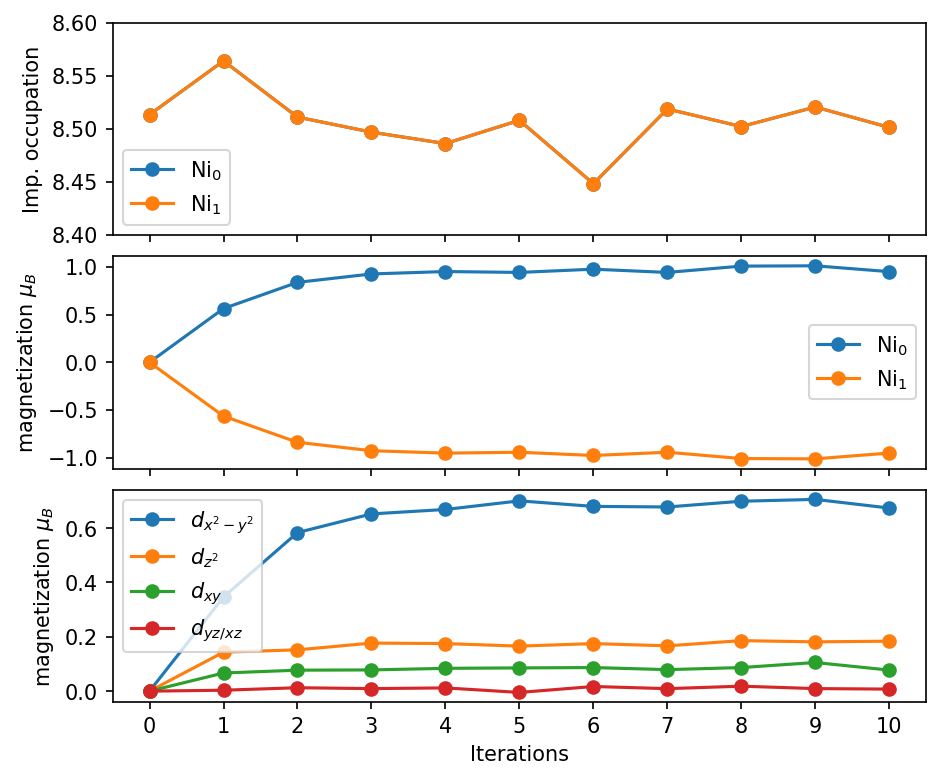

In [17]:
fig, ax = plt.subplots(nrows=3, dpi=150, figsize=(7,6), sharex=True)
fig.subplots_adjust(hspace=0.1)
# imp occupation
ax[0].plot(obs['iteration'], np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down']), '-o', label=r'Ni$_0$')
ax[0].plot(obs['iteration'], np.array(obs['imp_occ'][1]['up'])+np.array(obs['imp_occ'][1]['down']), '-o', label=r'Ni$_1$')

# imp magnetization
ax[1].plot(obs['iteration'], (np.array(obs['imp_occ'][0]['up'])-np.array(obs['imp_occ'][0]['down'])), '-o', label=r'Ni$_0$')
ax[1].plot(obs['iteration'], (np.array(obs['imp_occ'][1]['up'])-np.array(obs['imp_occ'][1]['down'])), '-o', label=r'Ni$_1$')

# dxy, dyz, dz2, dxz, dx2-y2 orbital magnetization
ax[2].plot(obs['iteration'], (np.array(obs['orb_occ'][0]['up'])[:,4]-np.array(obs['orb_occ'][0]['down'])[:,4]), '-o', label=r'$d_{x^2-y^2}$')
ax[2].plot(obs['iteration'], (np.array(obs['orb_occ'][0]['up'])[:,2]-np.array(obs['orb_occ'][0]['down'])[:,2]), '-o', label=r'$d_{z^2}$')
ax[2].plot(obs['iteration'], (np.array(obs['orb_occ'][0]['up'])[:,0]-np.array(obs['orb_occ'][0]['down'])[:,0]), '-o', label=r'$d_{xy}$')
ax[2].plot(obs['iteration'], (np.array(obs['orb_occ'][0]['up'])[:,1]-np.array(obs['orb_occ'][0]['down'])[:,1]), '-o', label=r'$d_{yz/xz}$')

ax[0].set_ylabel('Imp. occupation')
ax[1].set_ylabel(r'magnetization $\mu_B$')
ax[2].set_ylabel(r'magnetization $\mu_B$')
ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')
ax[0].set_ylim(8.4,8.6)
ax[0].legend();ax[1].legend();ax[2].legend()

plt.show()

Let's take a look at the self-energy of the two Ni $e_g$ orbitals:

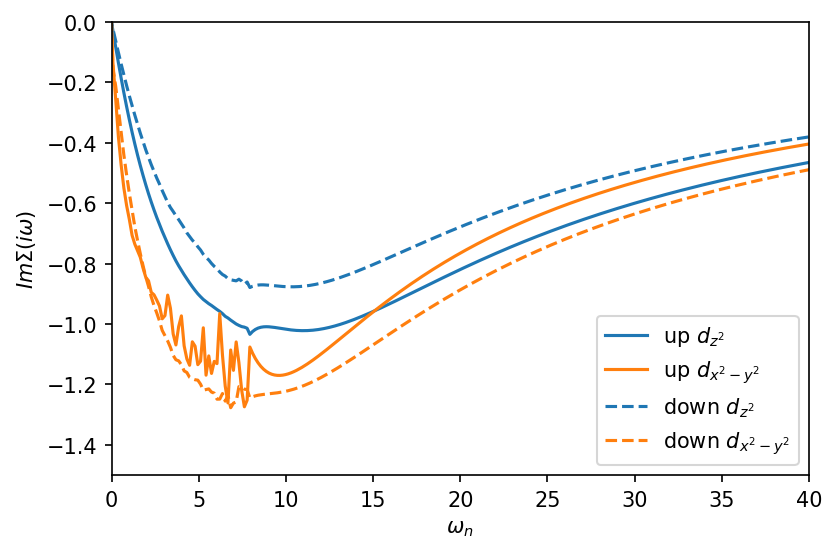

In [9]:
fig, ax = plt.subplots(1,dpi=150)

ax.oplot(Sigma_iw['up_2'].imag, '-', color='C0', label=r'up $d_{z^2}$')
ax.oplot(Sigma_iw['up_4'].imag, '-', color='C1', label=r'up $d_{x^2-y^2}$')

ax.oplot(Sigma_iw['down_2'].imag, '--', color='C0', label=r'down $d_{z^2}$')
ax.oplot(Sigma_iw['down_4'].imag, '--', color='C1', label=r'down $d_{x^2-y^2}$')

ax.set_ylabel(r"$Im \Sigma (i \omega)$")

ax.set_xlim(0,40)
ax.set_ylim(-1.5,0)
ax.legend()
plt.show()

We can clearly see that a $\omega_n=8$ the self-energy is replaced by the tail-fit as specified in the input config file. This cut is rather early, but ensures convergence. For higher sampling rates this has to be changed. We can also nicely observe a splitting of the spin channels indicating a magnetic solution, but we still have a metallic solution with both self-energies approaching 0 for small omega walues.

## 5. Multiplet analysis

We follow now the triqs/cthyb tutorial on the [multiplet analysis](https://triqs.github.io/cthyb/unstable/guide/multiplet_analysis_notebook.html) to analyze the multiplets of the Ni-d orbitals: 

In [10]:
import pandas as pd
pd.set_option('display.width', 130)

from triqs.operators.util import make_operator_real
from triqs.operators.util.observables import S_op
from triqs.atom_diag import quantum_number_eigenvalues
from triqs.operators import n

first we have to load the measured density matrix and the local Hamiltonian of the impurity problem from the h5 archive, which we stored by setting `measure_density_matrix=True` in the config file: 

In [11]:
with HDFArchive(path+'bak.NNO_lowT/nno.h5','r') as ar:
    rho = ar['DMFT_results/last_iter/full_dens_mat_0'] 
    h_loc = ar['DMFT_results/last_iter/h_loc_diag_0']

`rho` is just a list of arrays containing the weights of each of the impurity eigenstates (many body states), and `h_loc` is a: 

In [12]:
print(type(h_loc))

<class 'triqs.atom_diag.atom_diag.AtomDiagReal'>


containing the local Hamiltonian of the impurity including eigenstates, eigenvalues etc.

In [13]:
res = [] 
# get fundamental operators from atom_diag object
occ_operators = [n(*op) for op in h_loc.fops]

# construct total occupation operator from list
N_op = sum(occ_operators)

# create Sz operator and get eigenvalues
Sz=S_op('z', spin_names=['up','down'], orb_names=[0, 1, 2, 3, 4], off_diag=False)
Sz = make_operator_real(Sz)
Sz_states = quantum_number_eigenvalues(Sz, h_loc)

# get particle numbers from h_loc_diag
particle_numbers = quantum_number_eigenvalues(N_op, h_loc)
N_max = int(max(map(max, particle_numbers)))

for sub in range(0,h_loc.n_subspaces):

    # first get Fock space spanning the subspace
    fs_states = []
    for ind, fs in enumerate(h_loc.fock_states[sub]):
        state = bin(int(fs))[2:].rjust(N_max, '0')
        fs_states.append("|"+state+">")

    for ind in range(h_loc.get_subspace_dim(sub)):

        # get particle number
        particle_number = round(particle_numbers[sub][ind])
        if abs(particle_number-particle_numbers[sub][ind]) > 1e-8:
            raise ValueError('round error for particle number to large!',
                             particle_numbers[sub][ind])
        else:
            particle_number = int(particle_number)
        eng=h_loc.energies[sub][ind]

        # construct eigenvector in Fock state basis:
        ev_state = ''
        for i, elem in enumerate(h_loc.unitary_matrices[sub][:,ind]):
            ev_state += ' {:+1.4f}'.format(elem)+fs_states[i]

        # get spin state
        ms=Sz_states[sub][ind]

        # add to dict which becomes later the pandas data frame
        res.append({"Sub#" : sub,
                    "EV#" : ind,
                    "N" : particle_number,
                    "energy" : eng,
                    "prob": rho[sub][ind,ind],
                    "m_s": round(ms,1),
                    "|m_s|": abs(round(ms,1)),
                    "state": ev_state})
# panda data frame from res
res = pd.DataFrame(res, columns=res[0].keys())

In [14]:
print(res.sort_values('prob', ascending=False)[:10])

    Sub#  EV#   N    energy      prob  m_s  |m_s|                 state
5      5    0   9  0.331356  0.359575  0.5    0.5   +1.0000|1111101111>
0      0    0   8  0.000000  0.156004  1.0    1.0   +1.0000|1111101011>
2      2    0   9  0.241295  0.053509  0.5    0.5   +1.0000|1111111011>
25    25    0   8  1.147767  0.048450  0.0    0.0   +1.0000|1101101111>
40    40    0   8  1.629801  0.041584  1.0    1.0   +1.0000|1111101110>
55    55    0  10  7.059943  0.038929  0.0    0.0   +1.0000|1111111111>
15    15    0   8  0.637905  0.023181  1.0    1.0   +1.0000|1111101101>
4      4    0   9  0.331356  0.023174 -0.5    0.5   +1.0000|0111111111>
50    50    0   8  2.745626  0.023033  0.0    0.0   +1.0000|0111101111>
14    14    0   8  0.637905  0.022844  1.0    1.0   +1.0000|1111100111>


This table shows the eigenstates of the impurity with the highest weight / occurence probability. Each row shows the state of the system, where the 1/0 indicates if an orbital is occupied. The orbitals are ordered as given in the projectors (dxy, dyz, dz2, dxz, dx2-y2) from right to left, first one spin-channel, then the other. Additionally each row shows the particle sector of the state, the energy, and the `m_s` quantum number.

It can be seen, that the state with the highest weight is a state with one hole (N=9 electrons) in the $d_{x^2-y^2, up}$ orbital carrying a spin of `0.5`. The second state in the list is a state with two holes (N=8). One in the $d_{x^2-y^2, up}$ and one in the $d_{z^2, up}$ giving a magnetic moment of 1. This is because the impurity occupation is somewhere between 8 and 9. We can also create a nice state histogram from this: 

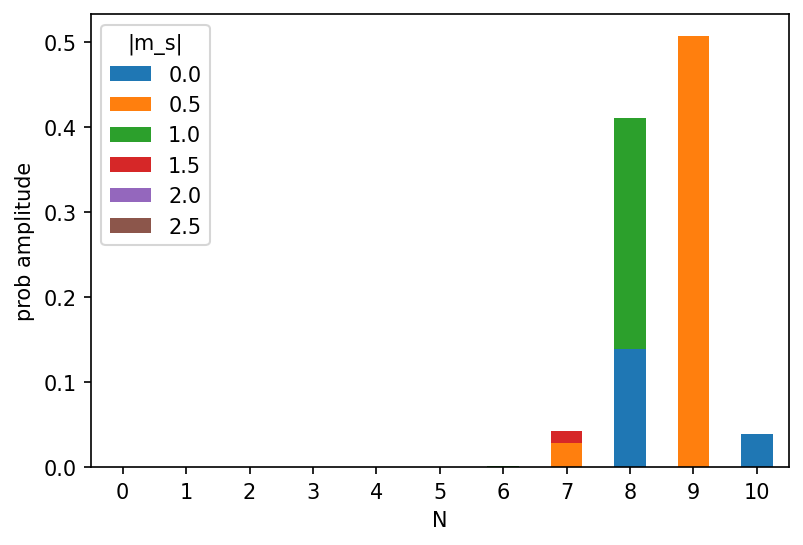

In [15]:
# split into ms occupations
fig, (ax1) = plt.subplots(1,1,figsize=(6,4), dpi=150)

spin_occ_five = res.groupby(['N', '|m_s|']).sum()
pivot_df = spin_occ_five.pivot_table(index='N', columns='|m_s|', values='prob')
pivot_df.plot.bar(stacked = True, rot=0, ax = ax1)

ax1.set_ylabel(r'prob amplitude')
plt.show()

This concludes the tutorial. This you can try next:

* try to find the transition temperature of the system by increasing the temperature in DMFT
* improve the accuracy of the resulting self-energy by restarting the dmft calculation with more n_cycles_tot 